In [60]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from datetime import timezone, datetime
import seaborn as sns
from matplotlib import pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [61]:
imputedMeasurementsDf = pd.read_csv('../../../../../../Data/ProcessedData/KnnImputed/measurementsImputedByKnn.csv')
measurementsDf = pd.read_csv('../../../../../../Data/RawData/rawMeasurementsFilteredBySensors.csv')

In [62]:
dateTimeDf = pd.DataFrame(measurementsDf['time'])

In [63]:
def iso8601ToDatetime():
    for i in range(len(dateTimeDf['time'])):
        timeContainer  = dateTimeDf['time'][i].replace('.000','')
        timeContainer = datetime.strptime(timeContainer, "%Y-%m-%dT%H:%M:%SZ")
        timeContainer = int(round(timeContainer.timestamp()))
        timeContainer = datetime.fromtimestamp(timeContainer)
        dateTimeDf['time'][i] = timeContainer

In [64]:
%%time

iso8601ToDatetime()

CPU times: total: 13.2 s
Wall time: 13.6 s


In [65]:
measurementsDf = dateTimeDf.join(imputedMeasurementsDf.drop(['day','month','hour'],axis = 1))

In [66]:
measurementsDf.head(20)

,time,T,Rn,H,P,CO2,sensor_id
0,2020-07-14 14:00:00,31.300000,1001.448424,44.475000,101.565847,567.750000,D0001
1,2020-07-14 15:00:00,31.333333,588.154974,45.505556,101.632854,636.361111,D0001
2,2020-07-14 16:00:00,31.451429,0.100000,47.145714,101.539128,734.000000,D0001
3,2020-07-14 17:00:00,31.161765,1042.843803,36.000000,101.501998,461.529412,D0001
4,2020-07-14 18:00:00,31.008333,1585.713833,28.436111,101.567130,400.000000,D0001
5,2020-07-14 19:00:00,30.647222,1585.713833,29.133333,101.567130,400.000000,D0001
6,2020-07-14 20:00:00,29.891429,1585.713833,28.597143,101.567130,400.000000,D0001
7,2020-07-14 21:00:00,29.118919,1585.713833,29.162162,101.567130,400.000000,D0001
8,2020-07-14 22:00:00,28.200000,1585.713833,31.611111,101.567130,400.000000,D0001
9,2020-07-14 23:00:00,28.280556,1389.856833,32.111111,101.296439,441.916667,D0001


In [67]:
measurementsDf.index =measurementsDf['time']

<AxesSubplot:xlabel='time'>

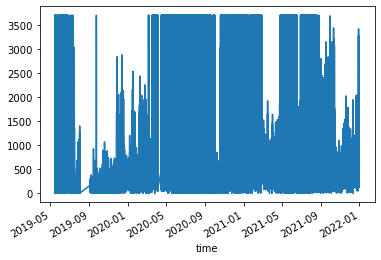

In [68]:
measurementsDf['Rn'].plot()

In [69]:
RadonDf =pd.DataFrame( measurementsDf['Rn'])
RadonDf 

,Rn
time,
2020-07-14 14:00:00,1001.448424
2020-07-14 15:00:00,588.154974
2020-07-14 16:00:00,0.100000
2020-07-14 17:00:00,1042.843803
2020-07-14 18:00:00,1585.713833
...,...
2021-12-31 19:00:00,616.640000
2021-12-31 20:00:00,541.380000
2021-12-31 21:00:00,544.167273


In [70]:
RadonDf['H'] = measurementsDf['H']
RadonDf['CO2'] = measurementsDf['CO2']
RadonDf['P'] = measurementsDf['P']
RadonDf['T'] = measurementsDf['T']
RadonDf

,Rn,H,CO2,P,T
time,,,,,
2020-07-14 14:00:00,1001.448424,44.475000,567.750000,101.565847,31.300000
2020-07-14 15:00:00,588.154974,45.505556,636.361111,101.632854,31.333333
2020-07-14 16:00:00,0.100000,47.145714,734.000000,101.539128,31.451429
2020-07-14 17:00:00,1042.843803,36.000000,461.529412,101.501998,31.161765
2020-07-14 18:00:00,1585.713833,28.436111,400.000000,101.567130,31.008333
...,...,...,...,...,...
2021-12-31 19:00:00,616.640000,50.156364,97.200000,102.653100,29.792673
2021-12-31 20:00:00,541.380000,48.047273,97.800000,102.273400,29.951673
2021-12-31 21:00:00,544.167273,53.847273,97.181818,102.199727,30.329218


In [71]:
from sklearn.metrics import mean_squared_error as mse

def predictions_plotter(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

In [93]:
#Converts the Df to a numpy array and then extracts the X and y value
#on the required format to train the model
def df_to_X_y(df, window_size=6):
    df_as_np = df.to_numpy() # converts the dataframe to a numpy array
    #Initialized  arrays to append X and Y values 
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        #Takes values from i to i + win size
        row =  [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        #The final output
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [79]:
X1, y1 = df_to_X_y(RadonDf)
X1.shape, y1.shape

((115628, 6, 5), (115628,))

In [80]:
X_train, y_train = X1[:92508], y1[:92508] # training data
X_val, y_val = X1[92508:95508], y1[92508:95508] #validation
X_test, y_test = X1[95508:], y1[95508:] #test
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((92508, 6, 5), (92508,), (3000, 6, 5), (3000,), (20120, 6, 5), (20120,))

 <h2> <font color='red'> LSTM implementation </font> <h2/> 

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((6, 5)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


In [82]:
cp = ModelCheckpoint('LSTM_model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), 
               optimizer=Adam(learning_rate=0.0001), 
               metrics=[RootMeanSquaredError()])

In [83]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
2891/2891 [==============================] - 28s 8ms/step - loss: 1583617.1250 - root_mean_squared_error: 1258.4185 - val_loss: 239347.5469 - val_root_mean_squared_error: 489.2316


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


Epoch 2/10
2891/2891 [==============================] - 22s 7ms/step - loss: 1425891.5000 - root_mean_squared_error: 1194.1069 - val_loss: 135680.8125 - val_root_mean_squared_error: 368.3488


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


Epoch 3/10
2891/2891 [==============================] - 21s 7ms/step - loss: 1253503.5000 - root_mean_squared_error: 1119.5997 - val_loss: 58923.5469 - val_root_mean_squared_error: 242.7417


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


Epoch 4/10
2891/2891 [==============================] - 23s 8ms/step - loss: 1075588.8750 - root_mean_squared_error: 1037.1060 - val_loss: 21282.8574 - val_root_mean_squared_error: 145.8865TA: 9s - l - ETA: 8s - loss: 1099018.5 - ETA: 1s - loss:


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


Epoch 5/10
2891/2891 [==============================] - 22s 8ms/step - loss: 890740.2500 - root_mean_squared_error: 943.7903 - val_loss: 12113.6885 - val_root_mean_squared_error: 110.0622


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


Epoch 6/10
2891/2891 [==============================] - 22s 8ms/step - loss: 706410.3125 - root_mean_squared_error: 840.4822 - val_loss: 9798.6025 - val_root_mean_squared_error: 98.9879


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


Epoch 7/10
2891/2891 [==============================] - 22s 8ms/step - loss: 531045.8750 - root_mean_squared_error: 728.7289 - val_loss: 9260.5625 - val_root_mean_squared_error: 96.2318


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


Epoch 8/10
2891/2891 [==============================] - 23s 8ms/step - loss: 371657.4375 - root_mean_squared_error: 609.6371 - val_loss: 9477.2285 - val_root_mean_squared_error: 97.3511
Epoch 9/10
2891/2891 [==============================] - 22s 8ms/step - loss: 236116.9531 - root_mean_squared_error: 485.9187 - val_loss: 9225.0322 - val_root_mean_squared_error: 96.0470


INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


Epoch 10/10
2891/2891 [==============================] - 22s 8ms/step - loss: 132391.3125 - root_mean_squared_error: 363.8562 - val_loss: 9448.3809 - val_root_mean_squared_error: 97.2028


In [84]:
model = load_model('LSTM_model/')

In [95]:
train_predictions = model.predict(X_train).flatten()
print(len(train_predictions))
print(len(y_train))
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

92508
92508


,Train Predictions,Actuals
0,1423.994385,1585.713833
1,1432.639404,1585.713833
2,1431.035767,1585.713833
3,1434.064575,1389.856833
4,1289.819824,1037.712333
...,...,...
92503,504.842041,513.676667
92504,481.758789,446.956667
92505,384.546478,496.132727
92506,472.317749,433.941667


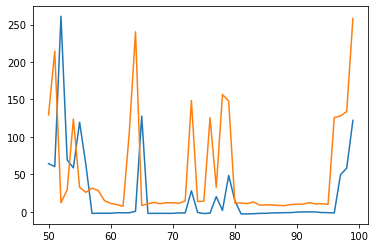

In [86]:
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [88]:
val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

,Val Predictions,Actuals
0,390.227478,469.725455
1,428.580078,438.566667
2,379.971191,419.945000
3,361.573212,434.873333
4,389.780029,421.390909
...,...,...
2995,634.066345,725.873333
2996,751.936707,740.021818
2997,712.858093,817.345833
2998,843.881226,953.915000


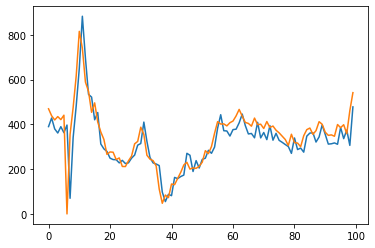

In [89]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [90]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

,Test Predictions,Actuals
0,938.472229,862.405000
1,821.455078,841.680000
2,821.451355,854.633333
3,828.664429,853.469000
4,819.257629,890.230000
...,...,...
20115,620.518799,616.640000
20116,583.991638,541.380000
20117,507.776459,544.167273
20118,517.717712,590.666000


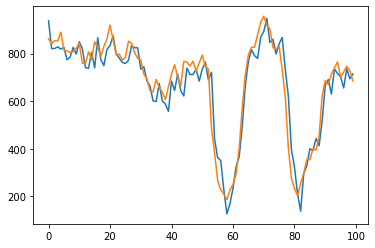

In [91]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

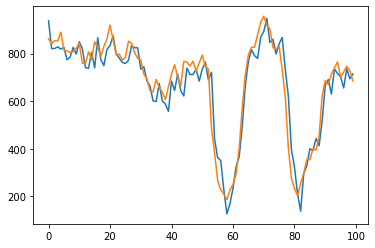

In [92]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])